In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import numpy as np
import jax
from functools import partial
from jax import jit
from jax import numpy as jnp
from jax import random
from matplotlib import pyplot as plt

from jwave import FiniteDifferences, FourierSeries
from jwave.geometry import Domain, Medium, circ_mask
from jwave.utils import display_complex_field, show_positive_field

import sys
sys.path.append('../') # add parent directory to sys path

# key = random.PRNGKey(42)  # Random seed

In [3]:
# define linear ultrasound transducer (P4-1)
nelements = 256
element_pitch = 2.95e-4 # distance between transducer elements
transducer_extent = (nelements - 1) * element_pitch # length of the transducer [m]
transducer_frequency = 1e6 # frequency of the transducer [Hz]
omega = 2 * np.pi * transducer_frequency # angular
transducer_magnitude = 1e6 # magnitude of the transducer [Pa]
print(f"Transducer extent: {transducer_extent:.3f} m")

Transducer extent: 0.075 m


In [9]:
import pydicom
import matplotlib.pyplot as plt

# Read the DICOM file
dcm_file = pydicom.dcmread("Skull Z_1201.dcm")

# Extract the pixel data
pixel_data = dcm_file.pixel_array

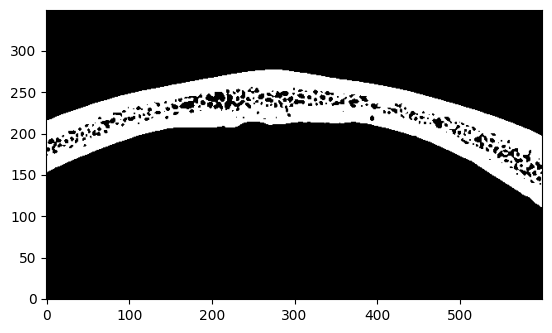

In [10]:
skull_piece = pixel_data[:250,600:1200]>20000
# Flip the skull piece on the y-axis
skull_piece = np.flipud(skull_piece)

# Add more rows of zeros at the top of the skull_piece
num_rows_to_add = 100  # You can adjust this number as needed
additional_rows = np.zeros((num_rows_to_add, skull_piece.shape[1]), dtype=skull_piece.dtype)
skull_piece = np.vstack((additional_rows, skull_piece))


plt.imshow(skull_piece, cmap="gray")
plt.gca().invert_yaxis()

In [11]:
from utils.jwave_utils import get_domain

# define spatial parameters
N = np.array(skull_piece.shape).astype(int) # grid size [grid points]
dx = np.array([9.07935931401377e-5, 9.07935931401377e-5]) # grid spacing [m]
pml = np.array([20, 20]) # size of the perfectly matched layer [grid points]

domain = get_domain(N, dx)

In [12]:
# define real transducer positions
transducer_width = pml[0] # width of the transducer [grid points]
transducer_y_start = N[1]//2 - nelements//2 # start index of the transducer in the y-direction [grid points]
element_positions = np.array([
    N[0] - 1 - transducer_width * np.ones(nelements),
    np.linspace(transducer_y_start, transducer_y_start + nelements - 1, nelements)
], dtype=int)

In [29]:
# get medium
speed_background = 1550
density_background = 1000

speed_skull = 2700
density_skull = 1800

speed_map = np.where(skull_piece == 1, speed_skull, speed_background)
density_map = np.where(skull_piece == 1, density_skull, density_background)

medium = Medium(
    domain,
    speed_map,
    density_map,
    pml_size=pml[0],
)

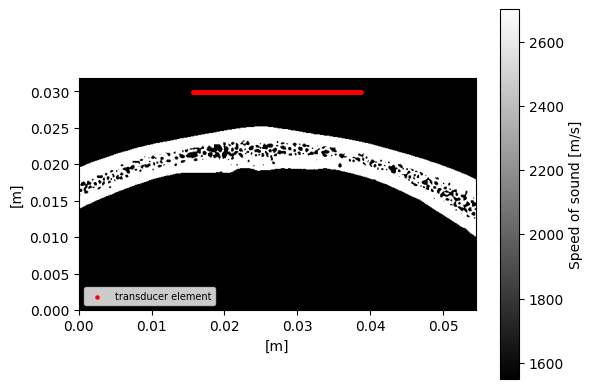

In [20]:
ext = [0, N[1]*dx[1], N[0]*dx[0], 0]
plt.scatter(element_positions[1]*dx[1], element_positions[0]*dx[0],
            c='r', marker='o', s=5, label='transducer element')
plt.imshow(medium.sound_speed, cmap='gray', extent=ext)
plt.colorbar(label='Speed of sound [m/s]')
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.legend(prop={'size': 7})
plt.gca().invert_yaxis()
plt.show()

In [21]:
from utils.jwave_utils import get_plane_wave_excitation
from jwave.geometry import TimeAxis

time_axis = TimeAxis.from_medium(medium, cfl=0.3)
angle = 0 * np.pi / 180
sources, signal, carrier_signal = get_plane_wave_excitation(domain, time_axis, transducer_magnitude, transducer_frequency, element_pitch, element_positions, angle=angle)

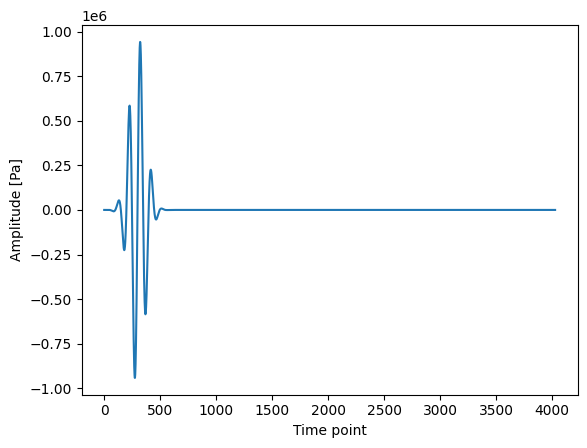

In [22]:
plt.plot(sources.signals[10])
plt.xlabel('Time point')
plt.ylabel('Amplitude [Pa]')
plt.show()

In [23]:
from utils.jwave_utils import get_data

# simulate data using jwave
pressure, _ = get_data(medium.sound_speed, medium.density, domain, time_axis, sources, element_positions)

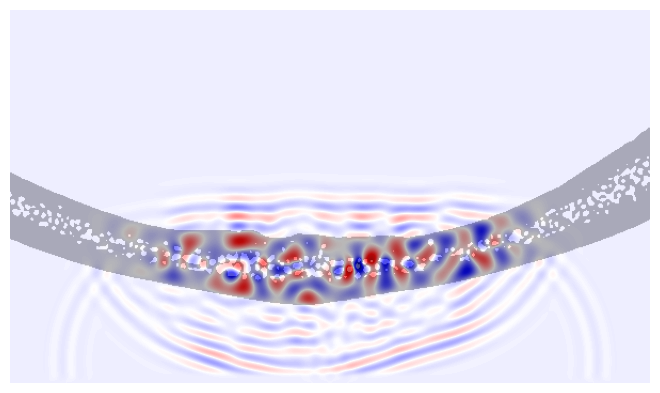

In [24]:
data = pressure.params
skull_mask = medium.sound_speed != speed_background

fig, ax = plt.subplots()
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Removes borders around the plot
ax.set_axis_off()

# Create a background image with white background and beige skull
background = np.ones_like(skull_mask, dtype=float)
background[skull_mask] = 0.1  # Beige color (adjust as needed)

# Plot the background
ax.imshow(background, cmap='gray', vmin=0, vmax=1)

# # Plot the pressure field on top with transparency
im = ax.imshow(data[1000], cmap='seismic', vmin=data.min(), vmax=data.max(), alpha=0.7)

In [25]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

def create_pressure_animation(data, skull_mask, output_filename='pressure_animation.mp4', duration=10, fps=24):
    # Set up the figure to be full-screen and eliminate white margins
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Removes borders around the plot

    # Hide axes and remove borders
    ax.set_axis_off()

    # Find global min and max for consistent colorscale
    vmin, vmax = data.min(), data.max()

    # Create a background image with white background and beige skull
    background = np.ones_like(skull_mask, dtype=float)
    background[skull_mask] = 0.1  # Beige color for skull

    # Plot the background with flipped y-axis
    bg_im = ax.imshow(background[::-1], cmap='gray', vmin=0, vmax=1)

    # Create the initial pressure plot on top of the background with flipped y-axis
    im = ax.imshow(data[0][::-1], cmap='seismic', vmin=vmin, vmax=vmax, alpha=0.7)

    # Calculate the number of frames for the movie
    total_frames = data.shape[0]
    frames_to_show = duration * fps
    frame_skip = max(1, total_frames // frames_to_show)

    # Set up the animation
    def animate(i):
        frame = i * frame_skip
        im.set_array(data[frame][::-1])  # Flip the y-axis for each frame
        return [im]

    # Create the animation
    anim = animation.FuncAnimation(fig, animate, frames=frames_to_show, interval=1000/fps, blit=True)

    # Save the animation without showing the colorbar, title, or axes
    anim.save(output_filename, fps=fps, writer='ffmpeg')

    plt.close(fig)  # Close the figure to free up memory

    print(f"Animation saved as '{output_filename}' ({duration} seconds duration, {fps} fps, showing every {frame_skip} frame(s))")

In [28]:
p = pressure.params[:pressure.params.shape[0]//2]
create_pressure_animation(p, skull_mask, output_filename=f'pressure_animation_{transducer_frequency/1e6:.1f}MHz.mp4', duration=5)

Animation saved as 'pressure_animation_1.0MHz.mp4' (5 seconds duration, 24 fps, showing every 16 frame(s))
